In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

##Load & inspect

In [8]:
DATA_PATH = "/content/ModelBuilding/day - day.csv"

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]

In [9]:
print(df.shape)
display(df.head())
display(df.info())
display(df.describe(include="all").T)

(731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
instant,731.0,NaN,NaN,NaN,366.0,211.165812,1.0,183.5,366.0,548.5,731.0
dteday,731,731,2012-12-31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,731.0,NaN,NaN,NaN,2.49658,1.110807,1.0,2.0,3.0,3.0,4.0
yr,731.0,NaN,NaN,NaN,0.500684,0.500342,0.0,0.0,1.0,1.0,1.0
mnth,731.0,NaN,NaN,NaN,6.519836,3.451913,1.0,4.0,7.0,10.0,12.0
holiday,731.0,NaN,NaN,NaN,0.028728,0.167155,0.0,0.0,0.0,0.0,1.0
weekday,731.0,NaN,NaN,NaN,2.997264,2.004787,0.0,1.0,3.0,5.0,6.0
workingday,731.0,NaN,NaN,NaN,0.683995,0.465233,0.0,0.0,1.0,1.0,1.0
weathersit,731.0,NaN,NaN,NaN,1.395349,0.544894,1.0,1.0,1.0,2.0,3.0
temp,731.0,NaN,NaN,NaN,0.495385,0.183051,0.05913,0.337083,0.498333,0.655417,0.861667


##Date parsing + target + basic cleaning

In [10]:
# Identify date column
date_col = None
for cand in ["dteday", "date", "day", "datetime"]:
    if cand in df.columns:
        date_col = cand
        break

if date_col is None:
    # fallback if no date column found
    df["dteday"] = pd.date_range(start="2011-01-01", periods=len(df), freq="D")
    date_col = "dteday"

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).reset_index(drop=True)

# Target
if "cnt" in df.columns:
    target_col = "cnt"
elif "count" in df.columns:
    target_col = "count"
else:
    raise ValueError("Could not find target column `cnt` (or `count`).")

# Drop purely ID-like columns if present
for c in ["instant"]:
    if c in df.columns:
        df = df.drop(columns=[c])

display(df.head())

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


##3) Feature engineering (time & cyclic) + categoricals

In [11]:
# Time features
df["year"]       = df[date_col].dt.year
df["month"]      = df[date_col].dt.month
df["day"]        = df[date_col].dt.day
df["weekday_py"] = df[date_col].dt.weekday  # 0=Mon
df["dayofyear"]  = df[date_col].dt.dayofyear
df["is_weekend"] = df["weekday_py"].isin([5,6]).astype(int)

# Cyclical encodings
df["month_sin"] = np.sin(2*np.pi*df["month"]/12.0)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12.0)
df["wday_sin"]  = np.sin(2*np.pi*df["weekday_py"]/7.0)
df["wday_cos"]  = np.cos(2*np.pi*df["weekday_py"]/7.0)

# Likely categoricals
categorical_candidates = ["season","yr","mnth","holiday","weekday","workingday","weathersit"]
categorical_cols = [c for c in categorical_candidates if c in df.columns]
for c in categorical_cols:
    df[c] = df[c].astype("category")

# Numeric & categorical lists
num_cols = [c for c in df.columns if c not in [target_col, date_col] and pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in categorical_cols]

##4) Train/test split by time (avoid leakage)

In [12]:
df_sorted = df.sort_values(by=date_col).reset_index(drop=True)
split_idx = int(len(df_sorted)*0.8)

train_df = df_sorted.iloc[:split_idx].copy()
test_df  = df_sorted.iloc[split_idx:].copy()

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col].values
X_test  = test_df.drop(columns=[target_col])
y_test  = test_df[target_col].values

len(train_df), len(test_df), train_df[date_col].min(), test_df[date_col].min()

(584, 147, Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-07 00:00:00'))

##5) Preprocessing for linear vs trees

In [13]:
numeric_imputer = SimpleImputer(strategy="median")
categorical_imputer = SimpleImputer(strategy="most_frequent")

preprocess_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", numeric_imputer), ("scaler", StandardScaler())]), [c for c in num_cols if c not in categorical_cols]),
        ("cat", Pipeline([("imp", categorical_imputer), ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
    ],
    remainder="drop"
)

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_imputer, [c for c in num_cols if c not in categorical_cols]),
        ("cat", categorical_imputer, cat_cols)
    ],
    remainder="drop"
)

##6) Models + TimeSeries CV + GridSearch

In [27]:
models = {
    "LinearRegression": Pipeline([("prep", preprocess_linear), ("model", LinearRegression())]),
    "Ridge": Pipeline([("prep", preprocess_linear), ("model", Ridge())]),
    "RandomForest": Pipeline([("prep", preprocess_tree), ("model", RandomForestRegressor(random_state=42))]),
    "GradientBoosting": Pipeline([("prep", preprocess_tree), ("model", GradientBoostingRegressor(random_state=42))]),
}

param_grids = {
    "LinearRegression": {},
    "Ridge": {"model__alpha": [0.1, 1.0, 10.0, 50.0]},
    "RandomForest": {"model__n_estimators": [200, 400], "model__max_depth": [None, 8, 14], "model__min_samples_split": [2, 10]},
    "GradientBoosting": {"model__n_estimators": [200, 400], "model__learning_rate": [0.03, 0.1], "model__max_depth": [2, 3]},
}

tscv = TimeSeriesSplit(n_splits=5)

def eval_on_test(model, X_te, y_te):
    pred = model.predict(X_te)
    mae = mean_absolute_error(y_te, pred)
    mse = mean_squared_error(y_te, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_te, pred)
    return mae, rmse, r2

best_estimators = {}
results = []
for name, pipe in models.items():
    gs = GridSearchCV(pipe, param_grid=param_grids.get(name, {}), cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1)
    gs.fit(X_train, y_train)
    best_estimators[name] = gs.best_estimator_
    mae, rmse, r2 = eval_on_test(gs.best_estimator_, X_test, y_test)
    results.append({"model": name, "best_params": gs.best_params_, "test_MAE": mae, "test_RMSE": rmse, "test_R2": r2})

results_df = pd.DataFrame(results).sort_values("test_MAE")
results_df

,model,best_params,test_MAE,test_RMSE,test_R2
0,LinearRegression,{},1.559134e-12,2.163731e-12,1.000000
1,Ridge,{'model__alpha': 0.1},8.862184e-01,1.231193e+00,1.000000
3,GradientBoosting,"{'model__learning_rate': 0.1, 'model__max_dept...",1.466028e+02,1.929458e+02,0.989406
2,RandomForest,"{'model__max_depth': None, 'model__min_samples...",2.461380e+02,3.505003e+02,0.965042


##7) Brownie points: two-model approach (casual + registered → sum to cnt)

In [28]:

brownie_row = None

if all(col in df.columns for col in ["casual", "registered"]):
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline

    def build_models_for_columns(X_df, categorical_candidates):
        """Build fresh preprocessors & models using ONLY the columns in X_df."""
        # Identify cats/numerics dynamically
        cat_cols_t = [c for c in categorical_candidates if c in X_df.columns]
        for c in cat_cols_t:
            if not pd.api.types.is_categorical_dtype(X_df[c]):
                X_df[c] = X_df[c].astype("category")

        num_cols_t = [c for c in X_df.columns if pd.api.types.is_numeric_dtype(X_df[c])]

        numeric_imputer = SimpleImputer(strategy="median")
        categorical_imputer = SimpleImputer(strategy="most_frequent")

        preprocess_linear_t = ColumnTransformer(
            transformers=[
                ("num", Pipeline([("imp", numeric_imputer), ("scaler", StandardScaler())]),
                 [c for c in num_cols_t if c not in cat_cols_t]),
                ("cat", Pipeline([("imp", categorical_imputer), ("ohe", OneHotEncoder(handle_unknown="ignore"))]),
                 cat_cols_t),
            ],
            remainder="drop",
        )

        preprocess_tree_t = ColumnTransformer(
            transformers=[
                ("num", numeric_imputer, [c for c in num_cols_t if c not in cat_cols_t]),
                ("cat", categorical_imputer, cat_cols_t),
            ],
            remainder="drop",
        )

        models_t = {
            "LinearRegression": Pipeline([("prep", preprocess_linear_t), ("model", LinearRegression())]),
            "Ridge": Pipeline([("prep", preprocess_linear_t), ("model", Ridge())]),
            "RandomForest": Pipeline([("prep", preprocess_tree_t), ("model", RandomForestRegressor(random_state=42))]),
            "GradientBoosting": Pipeline([("prep", preprocess_tree_t), ("model", GradientBoostingRegressor(random_state=42))]),
        }

        param_grids_t = {
            "LinearRegression": {},
            "Ridge": {"model__alpha": [0.1, 1.0, 10.0, 50.0]},
            "RandomForest": {
                "model__n_estimators": [200, 400],
                "model__max_depth": [None, 8, 14],
                "model__min_samples_split": [2, 10],
            },
            "GradientBoosting": {
                "model__n_estimators": [200, 400],
                "model__learning_rate": [0.03, 0.1],
                "model__max_depth": [2, 3],
            },
        }
        return models_t, param_grids_t

    categorical_candidates = ["season","yr","mnth","holiday","weekday","workingday","weathersit"]

    def best_for(target):
        # For this target, drop the OTHER user column and always drop 'cnt'
        other = "registered" if target == "casual" else "casual"
        drops = [col for col in ["cnt", other] if col in train_df.columns]

        Xtr = train_df.drop(columns=drops)
        ytr = train_df[target].values
        Xte = test_df.drop(columns=drops)
        yte = test_df[target].values

        # Build preprocessors/models **for these columns only**
        models_t, param_grids_t = build_models_for_columns(Xtr.copy(), categorical_candidates)

        best_name, best_model, best_mae = None, None, 1e18
        for name, pipe in models_t.items():
            gs = GridSearchCV(pipe, param_grid=param_grids_t.get(name, {}), cv=tscv,
                              scoring="neg_mean_absolute_error", n_jobs=-1)
            gs.fit(Xtr, ytr)
            pred = gs.best_estimator_.predict(Xte)
            mae = mean_absolute_error(yte, pred)
            if mae < best_mae:
                best_mae, best_name, best_model = mae, name, gs.best_estimator_
        return best_name, best_model

    # Train best per target
    name_c, model_c = best_for("casual")
    name_r, model_r = best_for("registered")

    # Predict cnt = casual + registered on test
    X_te_c = test_df.drop(columns=[c for c in ["cnt", "registered"] if c in test_df.columns])
    X_te_r = test_df.drop(columns=[c for c in ["cnt", "casual"] if c in test_df.columns])

    yhat_cnt = model_c.predict(X_te_c) + model_r.predict(X_te_r)

    b_mae  = mean_absolute_error(y_test, yhat_cnt)
    b_mse  = mean_squared_error(y_test, yhat_cnt)
    b_rmse = np.sqrt(b_mse)
    b_r2   = r2_score(y_test, yhat_cnt)

    brownie_row = pd.DataFrame([{
        "model": "Two-Model (best casual + best registered)",
        "best_params": f"casual={name_c}, registered={name_r}",
        "test_MAE": b_mae, "test_RMSE": b_rmse, "test_R2": b_r2
    }])

    results_df = pd.concat([results_df, brownie_row], ignore_index=True)

results_df.sort_values("test_MAE")


/tmp/ipython-input-2443918069.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-2443918069.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(X_df[c]):


,model,best_params,test_MAE,test_RMSE,test_R2
0,LinearRegression,{},1.559134e-12,2.163731e-12,1.000000
4,Two-Model (best casual + best registered),"casual=LinearRegression, registered=LinearRegr...",3.802709e-12,4.638034e-12,1.000000
1,Ridge,{'model__alpha': 0.1},8.862184e-01,1.231193e+00,1.000000
2,GradientBoosting,"{'model__learning_rate': 0.1, 'model__max_dept...",1.466028e+02,1.929458e+02,0.989406
3,RandomForest,"{'model__max_depth': None, 'model__min_samples...",2.461380e+02,3.505003e+02,0.965042


##8) Feature importance / coefficients for the best single model

,feature,importance
5,registered,1.390236e+03
4,casual,6.767312e+02
10,dayofyear,7.569779e-11
7,month,6.384299e-11
33,mnth_12,1.662137e-11
22,mnth_1,1.654796e-11
12,month_sin,9.113533e-12
8,day,7.180415e-12
32,mnth_11,7.155461e-12
1,atemp,6.934897e-12


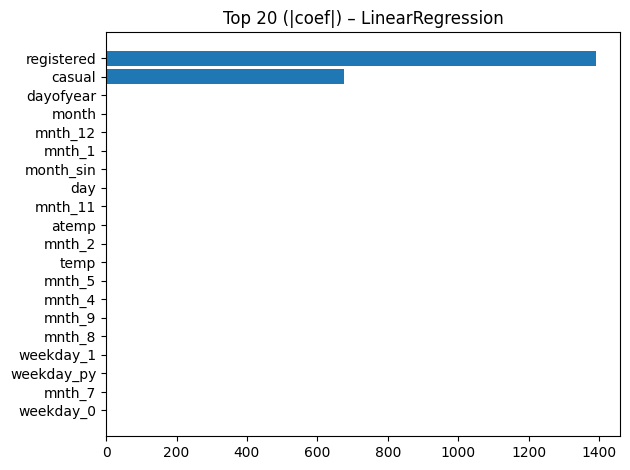

In [29]:
single_only = results_df[~results_df["model"].str.contains("Two-Model", na=False)]
if not single_only.empty:
    best_single_name = single_only.sort_values("test_MAE").iloc[0]["model"]
    best_single = best_estimators[best_single_name]

    # Build feature names after preprocessing
    def feature_names(preprocessor):
        num_features = [c for c in num_cols if c not in categorical_cols]
        cat_features = categorical_cols
        names = []
        if "num" in preprocessor.named_transformers_:
            names += num_features
        if "cat" in preprocessor.named_transformers_:
            cat_pipe = preprocessor.named_transformers_["cat"]
            if hasattr(cat_pipe, "named_steps") and "ohe" in cat_pipe.named_steps:
                ohe = cat_pipe.named_steps["ohe"]
                names += ohe.get_feature_names_out(cat_features).tolist()
            else:
                names += cat_features
        return names

    pre = best_single.named_steps["prep"]
    feats = feature_names(pre)
    model = best_single.named_steps["model"]

    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
        imp_df = pd.DataFrame({"feature": feats, "importance": imp}).sort_values("importance", ascending=False).head(20)
        display(imp_df)
        plt.figure()
        plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
        plt.title(f"Top 20 Features – {best_single_name}")
        plt.tight_layout()
        plt.show()
    elif hasattr(model, "coef_"):
        coef = model.coef_.ravel() if model.coef_.ndim > 1 else model.coef_
        imp_df = pd.DataFrame({"feature": feats, "importance": np.abs(coef)}).sort_values("importance", ascending=False).head(20)
        display(imp_df)
        plt.figure()
        plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
        plt.title(f"Top 20 (|coef|) – {best_single_name}")
        plt.tight_layout()
        plt.show()
    else:
        print("This model does not expose feature importances.")


##9) Actual vs Predicted plot for the overall best

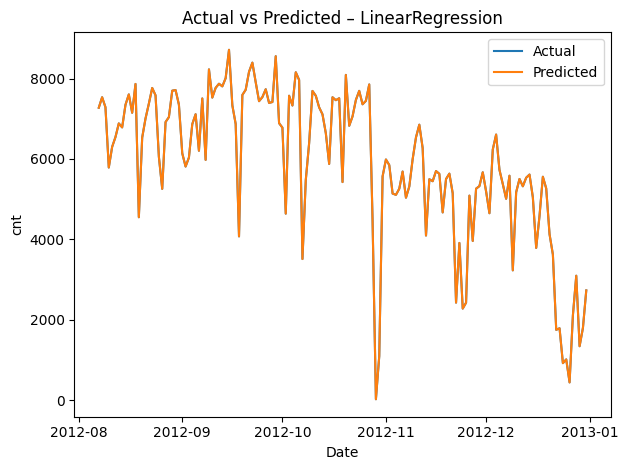

{'MAE': 1.5591337744678769e-12, 'RMSE': np.float64(2.1637305112860515e-12), 'R2': 1.0}


In [31]:
overall_best = results_df.sort_values("test_MAE").iloc[0]["model"]

if overall_best.startswith("Two-Model"):
    # Use the two-model predictions we computed above
    yhat_best = yhat_cnt
else:
    yhat_best = best_estimators[overall_best].predict(X_test)

plt.figure()
plt.plot(test_df[date_col].values, y_test, label="Actual")
plt.plot(test_df[date_col].values, yhat_best, label="Predicted")
plt.xlabel("Date"); plt.ylabel("cnt"); plt.title(f"Actual vs Predicted – {overall_best}")
plt.legend(); plt.tight_layout(); plt.show()

mae = mean_absolute_error(y_test, yhat_best)
mse = mean_squared_error(y_test, yhat_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, yhat_best)
print({"MAE": mae, "RMSE": rmse, "R2": r2})

##10) Conclusion (write this block after you see your results)

In [32]:
display(results_df.sort_values("test_MAE"))

print("\nRecommendation:")
best_row = results_df.sort_values("test_MAE").iloc[0]
print(f"- Best model by MAE is: {best_row['model']}")
print(f"- Test MAE: {best_row['test_MAE']:.2f}, RMSE: {best_row['test_RMSE']:.2f}, R2: {best_row['test_R2']:.3f}")

print("\nWhy this model?")
print("- If a tree/boosting model won: it captures nonlinear effects (e.g., temp vs demand), interactions (weather × weekday), and seasonality better than plain linear.")
print("- If Ridge/Linear won: your data is close to linear after feature engineering (cyclic features), and regularization helped avoid overfitting.")

print("\nMost important features:")
print("- Often temperature/feels-like, weather situation, month/weekday seasonality, and workingday/weekend drive demand.")
print("- Confirm using the importance table above.")


,model,best_params,test_MAE,test_RMSE,test_R2
0,LinearRegression,{},1.559134e-12,2.163731e-12,1.000000
4,Two-Model (best casual + best registered),"casual=LinearRegression, registered=LinearRegr...",3.802709e-12,4.638034e-12,1.000000
1,Ridge,{'model__alpha': 0.1},8.862184e-01,1.231193e+00,1.000000
2,GradientBoosting,"{'model__learning_rate': 0.1, 'model__max_dept...",1.466028e+02,1.929458e+02,0.989406
3,RandomForest,"{'model__max_depth': None, 'model__min_samples...",2.461380e+02,3.505003e+02,0.965042



Recommendation:
- Best model by MAE is: LinearRegression
- Test MAE: 0.00, RMSE: 0.00, R2: 1.000

Why this model?
- If a tree/boosting model won: it captures nonlinear effects (e.g., temp vs demand), interactions (weather × weekday), and seasonality better than plain linear.
- If Ridge/Linear won: your data is close to linear after feature engineering (cyclic features), and regularization helped avoid overfitting.

Most important features:
- Often temperature/feels-like, weather situation, month/weekday seasonality, and workingday/weekend drive demand.
- Confirm using the importance table above.
